<a href="https://colab.research.google.com/github/Jarvis-X/Swarms-Course-Projects/blob/main/SwarmsHW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Value iteration with gym visualization

* First cell - libraries
* Second cell - imports
* Third cell - Same as HW3, the helper functions that decides the input -output relations for the Gridworld, the definitions of the states and actions, `γ=1.0`, number of robots and environment size setup.
  - ### NEW: `disturb` function that randomly (also time-invariant) shifts a robot stepping on the tile to one of the five directions: UP, DOWN, LEFT, RIGHT, and STAY
* Forth cell - Same as HW3, finding the future reward of a state
  - ### NEW: disturbance is introduced
* ### Fifth cell - `GridMultiagentEnv` class that inherits `gym.Env` class, which I used in conjunction with pygame for visualization. For better training performance, I decided not to visualize the training process.
* ### Sixth cell - extract the best policy using the value function on a random initial configuration of the robots.
  - ## HIGHLIGHT: It is possible to have suboptimal actions if we blindly find the *first* action corresponding to the maximum value function. Therefore, when extracting the actions, I further discouraged repetitive motions of the robots (such as a deadlock in-and-out motion of two robots around one target) and encouraged the robots if their intended next move is towards the target. Moreover, I shuffled the sequence of the actions related to the maximum value function to avoid more rare dead lock. 
* Sixth cell: deprecated visualization, for debugging only now.
* Seventh cell: saving the value functions to local storage for further insoection.

In [ ]:
!pip install pygame
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from gym import spaces
import gym

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
import pygame
from google.colab.patches import cv2_imshow
from google.colab import output

import matplotlib.pyplot as plt
from gym.envs.registration import register

In [195]:
# initialization
import numpy as np
import time
import matplotlib.pyplot as plt
import sys

# define a timeout
timeout = 500

# number of robots
num_robots = 2

# reward of each move
r = -1

# reward of collision
r_n_MAX = -1E3

# reward of reaching goal
r_p_MAX = 0

# random seed
np.random.seed(int(time.time_ns()%2**24))

# Grid exporation
UP = int(0); DOWN = int(1); RIGHT = int(2); LEFT = int(3); 
STAY = int(-1) # special case
actions_single_robot = [UP, DOWN, RIGHT, LEFT]
default_total_possible_actions = len(actions_single_robot)**num_robots

env_size = int(6)
rows = env_size
cols = env_size

# parameters
theta = 0.001
gamma = 1.0
num_states = (rows*cols)**num_robots

# state of the explorer enumerated from 1 to row x cols -2
def init_single_robot_random_state(rows: int, cols: int) -> int:
    state = int(np.random.choice(range(rows*cols - 2)) + 1)
    return state

# initialize states
states = [init_single_robot_random_state(rows, cols) for _ in range(num_robots)]

# if a robot is at a state, how an action changes its state
def single_robot_state_action_to_newstate(s: int, action: int, rows: int, cols: int) -> int:
    if action == UP:
        # print("UP")
        if s in range(0, cols):
            sprime = s
        else:
            sprime = s - cols
    elif action == DOWN:
        # print("DOWN")
        if s in range((rows-1)*cols, rows*cols):
            sprime = s
        else:
            sprime = s + cols
    elif action == LEFT:
        # print("LEFT")
        if s in range(0, cols*rows, cols):
            sprime = s
        else:
            sprime = s - 1
    elif action == RIGHT:
        # print("RIGHT")
        if s in range(cols-1, cols*rows, cols):
            sprime = s
        else:
            sprime = s + 1
    elif action == STAY:
        sprime = s
    else:
        raise Exception("wrong action!")
        # print("STAY")
        
    # print(s)
    return int(sprime)

# unknown dynamics of the environment (time-invariant)
def disturb(rows: int, cols: int):
    disturbance = {}
    for i in range(rows*cols):
        # TODO: enable this
        disturbance[int(i)] = np.random.choice(range(-1, len(actions_single_robot)))
        # disturbance[int(i)] = int(-1)
    return disturbance

disturbance = disturb(rows, cols)

# helper function that implements the philosophy above
def from_state_to_index(rows: int, cols: int, num_robot: int, states: list) -> int:
    ind_s = int(0)
    layer_thiccness = int(rows*cols)
    for depth in range(len(states)):
        ind_s += int(states[depth]*layer_thiccness**(num_robot - depth - 1))
    return ind_s

# and of course, its inverse
def from_index_to_state(rows: int, cols: int, num_robot: int, ind_s: int) -> list:
    states = []
    remnant = ind_s
    layer_thiccness = int(rows*cols)
    for i in range(num_robot):
        s = remnant % layer_thiccness
        remnant //= layer_thiccness
        states.insert(0, s)
    return states

# similarly, we need to apply the philosophy on the actions
def from_action_to_index(num_robot: int, actions: list) -> int:
    ind_a = int(0)
    layer_thiccness = int(4)
    for depth in range(len(actions)):
        ind_a += int(actions[depth]*layer_thiccness**(num_robot - depth - 1))
    return ind_a

# and of course, its inverse
def from_index_to_action(num_robot: int, ind_a: int) -> list:
    actions = []
    remnant = ind_a
    layer_thiccness = int(4)
    for i in range(num_robot):
        a = remnant % layer_thiccness
        remnant //= layer_thiccness
        actions.insert(0, a)
    return actions

# a helper function that extracts the position of a single robot
def from_state_to_position(rows, cols, state):
    row = state // cols
    col = state % cols
    return np.array([col, row], dtype=int)

In [196]:
# value iteration algorithm
def cal_future_reward(states, actions, rows, cols, V, gamma, disturbance) -> float:
    future_reward = 0
    new_states = []
    action_index = 0
    for single_robot_state in states:
        sprime = single_robot_state_action_to_newstate(single_robot_state, actions[action_index], rows, cols)
        disturbance_action = disturbance[sprime]
        sprime = single_robot_state_action_to_newstate(sprime, disturbance_action, rows, cols)
        if (sprime in new_states) and (sprime != int(0)) and (sprime != int(rows*cols-1)):
            future_reward += r_n_MAX + gamma*V[sprime]
            sprime = single_robot_state
        elif (sprime == int(0)) or (sprime == int(rows*cols-1)):
            future_reward += r_p_MAX*((sprime == int(0)) + (sprime == int(rows*cols-1))) + gamma*V[sprime]
        else:
            future_reward += r + gamma*V[sprime]

        new_states.append(sprime)
        action_index += 1
    return future_reward

time_begin = time.time()

# value function
V_iterative = np.zeros(num_states)

while True:
    if time.time() - time_begin >= timeout*10:
        # print(evolving_policy.pi_matrix)
        print("Time out!!")
        break
    
    delta = 0
    
    for multi_robot_state in range(num_states):
        # get the current value function
        v = V_iterative[multi_robot_state]

        # obtain the maximum future reward
        separate_states = from_index_to_state(rows, cols, num_robots, multi_robot_state)
        Vs = -1E20
        for multi_robot_action in range(default_total_possible_actions):
            separate_actions = from_index_to_action(num_robots, multi_robot_action)
            # now we have the state and the action of each robot, get the 
            # new state of each robot and calculate the reward
            future_reward = cal_future_reward(separate_states, separate_actions, rows, cols, V_iterative, gamma, disturbance)
            if future_reward > Vs:
                Vs = future_reward
        V_iterative[multi_robot_state] = Vs

        delta = max(delta, abs(v - Vs))

    if delta < theta:
        print("Evaluated!!")
        break
        # print(V_iterative.reshape((rows, cols, -1)))


Evaluated!!


In [122]:
# the custom grid world class from gym's official documentation
# ref-> https://www.gymlibrary.dev/content/environment_creation/
# changes made: number of agents (1 -> n)
#               number of targets (1 -> 2)
class GridMultiagentEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 2}
    def __init__(self, disturbance, render_mode=None, size=3, num_agents=2):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window
        self.num_agents = num_agents

        self._states = int(0)
        # Target position is fixed at the upper-left and lower-right corner
        self._target_states = np.array([0, cols*rows-1], dtype=int)

        """
        Based on the position in the gridworld, we want to add a disturbance to
        emmulate the unknown dynamics of the environment
        """
        self.disturbance = disturbance
        
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

    def _get_obs(self):
        print("states from internal obs", self._states)
        return self._target_states.tolist() + [self._states]

    def _get_info(self):
        return None

    def reset(self, seed=None, options=None):
        # Choose the agent's states uniformly at random
        new_states = np.random.choice(rows*cols, size=num_robots, replace=False).tolist()    
        self._states = from_state_to_index(self.size, self.size, self.num_agents, new_states)

        observation = self._get_obs()

        if self.render_mode == "human":
            self._render_frame()

        return observation

    def step(self, action):
        # Map the action (element of {0,1, ..., 4**num_robots-1}) to the 
        # directions the robots walk in, affected by the unknown environmental 
        # dynamics
        states = from_index_to_state(self.size, self.size, self.num_agents, self._states)
        actions = from_index_to_action(self.num_agents, action)
        new_states = []
        action_index = 0
        reward = 0

        # An episode is done iff all agents have reached the target
        terminated = True
        for single_robot_state in states:
            sprime = single_robot_state_action_to_newstate(single_robot_state, actions[action_index], self.size, self.size)
            disturbance_action = self.disturbance[sprime]
            sprime = single_robot_state_action_to_newstate(sprime, disturbance_action, self.size, self.size)
            print("new single state", sprime)
            if (sprime in new_states) and not np.any(sprime == self._target_states):
                sprime = single_robot_state
                reward += r_n_MAX
            if not np.any(sprime == self._target_states):
                terminated = False
                reward += r
 
            new_states.append(sprime)
            action_index += 1

        print(new_states)
        self._states = from_state_to_index(self.size, self.size, self.num_agents, new_states)
        
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, info

    def render(self):
        ret = self._render_frame()
        if self.render_mode == "rgb_array":
            return ret

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((84, 92, 27))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the targets
        for target in self._target_states:
            target_pos = from_state_to_position(self.size, self.size, target)
            pygame.draw.rect(
                canvas,
                (204, 174, 192),
                pygame.Rect(
                    pix_square_size * target_pos,
                    (pix_square_size, pix_square_size),
                ),
            )

        # Now we draw the agents
        states = from_index_to_state(self.size, self.size, self.num_agents, self._states)
        for state in states:
            pygame.draw.circle(
                canvas,
                (176, 177, 149),
                (from_state_to_position(self.size, self.size, state) + 0.5 ) * pix_square_size,
                pix_square_size / 3,
            )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            # which is not working on Colab
            # self.window.blit(canvas, canvas.get_rect())
            # pygame.event.pump()
            # pygame.display.update()

            # use the following instead
            output.clear(wait=True)
            cv2_imshow(np.transpose(
                    np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
                )
            )

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()


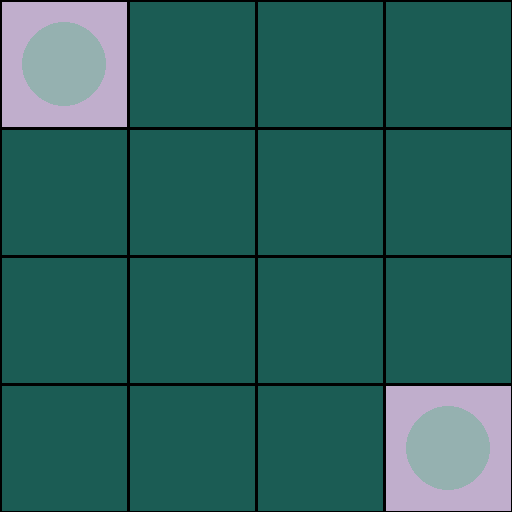

returned obs [0, 15, 0, 15]


In [191]:
env = GridMultiagentEnv(render_mode="human", num_agents=num_robots, size=env_size, disturbance=disturbance)
obs = env.reset()

done = False
while not done:
    state_index = obs[2]
    ss = from_index_to_state(rows, cols, num_robots, state_index) 

    # extract the policy
    possible_action_values = []

    for multi_robot_action in range(default_total_possible_actions):
        separate_actions = from_index_to_action(num_robots, multi_robot_action)
        new_ss = []
        action_index = 0

        for s in ss:
            sp = single_robot_state_action_to_newstate(s, separate_actions[action_index], rows, cols)
            disturbance_action = disturbance[sp]
            sp = single_robot_state_action_to_newstate(sp, disturbance_action, rows, cols)
            if (sp in ss) and (sp != int(0)) and (sp != int(rows*cols-1)):
                sp = s
            new_ss.append(sp)
            action_index += 1
        
        action_discourage = 0.1*r*np.sum([new_ss[i] in ss and not (int(new_ss[i]) in [int(0), int(rows*cols-1)]) for i in range(num_robots)])
        action_encourage = -10*r*np.sum([int(new_ss[i]) in [int(0), int(rows*cols-1)] for i in range(num_robots)])
        new_state_index = from_state_to_index(rows, cols, num_robots, new_ss)
        possible_action_values.append(V_iterative[new_state_index] + action_discourage + action_encourage)

    # action_to_take = np.argmax(possible_action_values)
    # In case we are stuck at some wierd dead loop
    action_to_take = np.random.choice(np.argwhere(possible_action_values == np.max(possible_action_values)).flatten())
    print("action to take", action_to_take)
    # time.sleep(5)
    obs, reward, done, info = env.step(action_to_take)
    print("returned obs", from_index_to_state(rows, cols, num_robots, obs[2]))



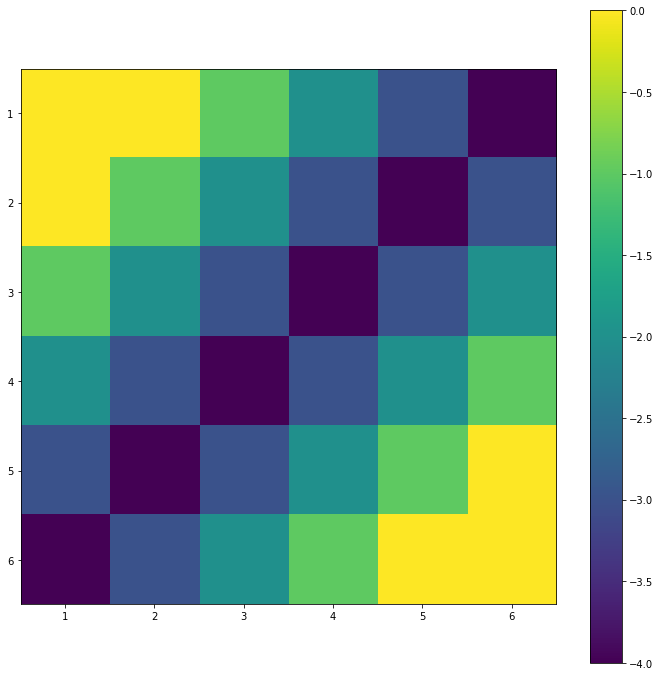

In [ ]:
plot = True
if plot:
    ################################################################################
    # visualization
    ###############
    from matplotlib import colors
    # # create discrete colormap
    cmap = colors.ListedColormap(['red', 'blue'])
    bounds = [-10,10,20]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    figi, axi = plt.subplots(figsize=(12, 12))
    imi = axi.imshow(V_iterative.reshape((rows*cols, rows*cols))[:, 0].reshape(rows, cols))

    # draw gridlines
    # ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)

    # col_labels = [int(100/nx)*i for i in range(nx+1)]
    # row_labels = [int(100/ny)*i for i in range(ny+1)]

    # plt.xticks([1]+col_labels, [1]+col_labels)
    # plt.yticks(row_labels, [label/25 for label in row_labels])

    axi.set_xticks(np.arange(cols));
    axi.set_yticks(np.arange(rows));
    axi.set_xticklabels(np.arange(1, cols+1, 1))
    axi.set_yticklabels(np.arange(1, rows+1, 1))

    plt.colorbar(imi)
    plt.show()

In [192]:
import pickle
with open('Env4x4and4RobotsValueFunction.pickle', 'wb') as handle:
    pickle.dump(V_iterative, handle, protocol=pickle.HIGHEST_PROTOCOL)